# The Habitual Action Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that maximise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting



In [1]:
from util import random_observation_sequence, transform_observations
import matplotlib.pyplot as plt
import gym

from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
env = gym.make('MountainCarContinuous-v0')
env.action_space.seed(42)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

all_observations = []
all_observations_scaled = []
actions = []
rewards = []
num_episodes = 1

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]

t_max = 1000

for i in range(num_episodes):
    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # o_scaled = transform_observations(o, observation_max, observation_min, obs_stddev)
    o_scaled = o
    actions.append(a)

    rewards.append(r)

    # o = transform_observations(o, observation_max, observation_min, [0, 0])

    all_observations_scaled.append(o_scaled)
    all_observations.append(o[:-1])

all_observations = np.vstack(all_observations)
all_observations_scaled = np.vstack(all_observations_scaled)
actions = np.vstack(actions)
rewards = np.vstack(rewards).T
# rewards = rewards.reshape(rewards.shape[0])
print(all_observations.shape, actions.shape, rewards.shape)

(335, 2) (335, 1) (335, 1)


In [4]:
all_observations

array([[-0.45521414,  0.        ],
       [-0.4557704 , -0.00055628],
       [-0.45687887, -0.00110847],
       ...,
       [ 0.3737965 ,  0.03084939],
       [ 0.4045728 ,  0.03077632],
       [ 0.4354883 ,  0.03091549]], dtype=float32)

In [5]:
act_net = HabitualAction(2, 1, [100])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 z_mean (Dense)              (None, 1)                 101       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [6]:
print(rewards.shape)

(970, 1)


In [7]:
cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)
cum_rewards.shape

(970, 1)

In [8]:
a_mean = act_net(all_observations, training=True)  # Forward pass

# print(a_mean, true_actions)
a_mean

<tf.Tensor: shape=(970, 1), dtype=float32, numpy=
array([[0.02020267],
       [0.02013358],
       [0.02008965],
       [0.02007126],
       [0.02007852],
       [0.02011137],
       [0.02016957],
       [0.02025271],
       [0.02036019],
       [0.02049119],
       [0.02064477],
       [0.02098242],
       [0.0212809 ],
       [0.02153802],
       [0.02175184],
       [0.02192076],
       [0.0220659 ],
       [0.02218674],
       [0.02225931],
       [0.02228307],
       [0.02225781],
       [0.02218377],
       [0.02184026],
       [0.02150939],
       [0.02119366],
       [0.0208954 ],
       [0.02061683],
       [0.02036001],
       [0.0201268 ],
       [0.01991892],
       [0.01973791],
       [0.01960007],
       [0.01950587],
       [0.01944175],
       [0.0194082 ],
       [0.01940545],
       [0.01943353],
       [0.01951986],
       [0.01962632],
       [0.01975215],
       [0.01989641],
       [0.02005808],
       [0.02023596],
       [0.02042873],
       [0.02063501],
     

In [9]:
"""
log_loss = log_likelihood_gaussian(a_mean, actions, 0.05**2, use_consts=False)
weighted_log_loss = log_loss * cum_rewards

print(log_loss)
print(weighted_log_loss)

# need to multiply by negative one because neural net does gradient descent not ascent
neg_weighted_log_loss = -1 * weighted_log_loss
print(neg_weighted_log_loss)"""

'\nlog_loss = log_likelihood_gaussian(a_mean, actions, 0.05**2, use_consts=False)\nweighted_log_loss = log_loss * cum_rewards\n\nprint(log_loss)\nprint(weighted_log_loss)\n\n# need to multiply by negative one because neural net does gradient descent not ascent\nneg_weighted_log_loss = -1 * weighted_log_loss\nprint(neg_weighted_log_loss)'

In [10]:
act_net.fit(all_observations, (actions, cum_rewards), batch_size=all_observations.shape[0], epochs=100)

act_net.train_on_batch(all_observations, (actions, cum_rewards))

Epoch 1/100
1/1 [==============================] - 0s 123ms/step - loss: 5829390336.0000
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 5801392640.0000
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 5778953728.0000
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 5761462272.0000
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 5747443712.0000
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 5735106560.0000
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 5722819584.0000
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 5709958144.0000
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 5696483328.0000
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 5682567168.0000
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 5668399616.0000
Epoch 12/100
1/1 [=====================

2022-09-28 11:33:25.256425: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 2ms/step - loss: 5503170048.0000
Epoch 23/100
1/1 [==============================] - 0s 2ms/step - loss: 5488627712.0000
Epoch 24/100
1/1 [==============================] - 0s 3ms/step - loss: 5474074112.0000
Epoch 25/100
1/1 [==============================] - 0s 2ms/step - loss: 5459816960.0000
Epoch 26/100
1/1 [==============================] - 0s 2ms/step - loss: 5445848064.0000
Epoch 27/100
1/1 [==============================] - 0s 2ms/step - loss: 5431922688.0000
Epoch 28/100
1/1 [==============================] - 0s 3ms/step - loss: 5417995264.0000
Epoch 29/100
1/1 [==============================] - 0s 2ms/step - loss: 5404314624.0000
Epoch 30/100
1/1 [==============================] - 0s 2ms/step - loss: 5390974464.0000
Epoch 31/100
1/1 [==============================] - 0s 2ms/step - loss: 5377825280.0000
Epoch 32/100
1/1 [==============================] - 0s 2ms/step - loss: 5364979712.0000
Epoch 33/100
1/1 [===========================

5157334528.0

## How about multiple runs?

In [11]:
act_net = HabitualAction(2, 1, [16, 16])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                48        
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 z_mean (Dense)              (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [12]:
t_max = 1000
num_episodes = 250

min_reward_cutoff = -1000
min_reward_set = -0.5

time_ratio = 6

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []



    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    o = transform_observations(o, observation_max, observation_min, obs_stddev)
    actions.append(a[::time_ratio])
    rewards.append(r[::time_ratio])

    all_observations.append(o[:-1][::time_ratio])

    all_observations = np.vstack(all_observations)
    all_observations_scaled = np.vstack(all_observations_scaled)
    actions = np.vstack(actions)
    rewards = np.vstack(rewards).T
    rewards[rewards < min_reward_cutoff] = min_reward_set

    # print(rewards)

    # rewards = rewards.reshape(rewards.shape[1])

    # print(all_observations.shape, actions.shape, rewards.shape)

    cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)
    # cum_rewards

    cum_rewards = cum_rewards

    # print(cum_rewards.shape[0])
    loss = act_net.train_on_batch(all_observations, (actions, cum_rewards))
    print(loss)

-20585.21484375
-2064388.125
-622843.4375
-53861.64453125
-50854.015625
-3526700.0
-509343.0625
-23354.123046875
-83015.7265625
-138473.875
-9414.6787109375
34284944.0
-355561.65625
-12472.755859375
139740512.0
-202616.875
16745212.0
-11120.294921875
-765545.4375
-855764.75
-168135.75
-4498146.5
-411609.625
-136100.0
145282976.0
-1267409.375
-53324.6796875
-5137371.0
-50540.015625
-5810107.5
-1383053.125
-1859579.75
-3183445.0
-88704.140625
-1229675.5
-55528.625
-585518.0
-3121145.25
-722090.0
-128105.8671875
-487665.1875
56427720.0
-149952.890625
-106389.875
-1817530.25
51811480.0
-1504947.0
-4389050.0
-350657.375
-91882.5859375
-4631799.0
-4697493.0
-505891.34375
-3723966.75
-512351.5625
-3939154.5
-61529.1484375
-325106.375
-507179.25
14639782.0
29638484.0
52140160.0
-91854.59375
-4117241.75
-865548.875
-114512.3984375
-145635.9375
-3790410.0
-4881.49169921875
4592624.5
8704156.0
-3882638.25
-6884134.5
-3177201.0
-3031652.25
-3175160.0
25652936.0
-74108.9921875
-145324.703125
-27228

In [13]:
act_net(all_observations)

<tf.Tensor: shape=(167, 1), dtype=float32, numpy=
array([[ 0.02603564],
       [ 0.06036368],
       [ 0.06667491],
       [ 0.06388176],
       [ 0.05262858],
       [ 0.01956768],
       [ 0.00315117],
       [ 0.00171675],
       [-0.02169306],
       [-0.04722264],
       [-0.06041193],
       [-0.05896343],
       [-0.05862816],
       [-0.04095935],
       [-0.00623558],
       [ 0.02735129],
       [ 0.06485953],
       [ 0.08927733],
       [ 0.08838   ],
       [ 0.05998561],
       [ 0.05425962],
       [-0.01255992],
       [-0.06445726],
       [-0.09682971],
       [-0.14923325],
       [-0.16072063],
       [-0.03293559],
       [ 0.05745721],
       [ 0.09576335],
       [ 0.10534193],
       [ 0.07876883],
       [ 0.08801456],
       [ 0.02628905],
       [-0.05318325],
       [-0.09875707],
       [-0.09011927],
       [-0.09807131],
       [-0.12767005],
       [-0.12275259],
       [-0.00984604],
       [ 0.04565801],
       [ 0.05900328],
       [ 0.07062165],
    

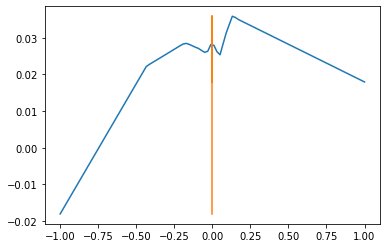

In [14]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = act_net(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[-0.22466275]
 [-0.22016472]
 [-0.21565726]
 [-0.21114065]
 [-0.20661494]
 [-0.20208044]
 [-0.19753724]
 [-0.19298549]
 [-0.18842548]
 [-0.18385732]
 [-0.17928116]
 [-0.17469727]
 [-0.17010579]
 [-0.16550691]
 [-0.1609008 ]
 [-0.1562877 ]
 [-0.15166776]
 [-0.14704119]
 [-0.14240816]
 [-0.13776892]
 [-0.13312358]
 [-0.12847242]
 [-0.12381555]
 [-0.11915328]
 [-0.11448572]
 [-0.10981311]
 [-0.10513563]
 [-0.10045349]
 [-0.09576691]
 [-0.09107609]
 [-0.08638121]
 [-0.08168248]
 [-0.07698014]
 [-0.07227435]
 [-0.06756535]
 [-0.06285334]
 [-0.05813853]
 [-0.05342111]
 [-0.04870132]
 [-0.04397935]
 [-0.0392554 ]
 [-0.03452972]
 [-0.02982068]
 [-0.02529095]
 [-0.02076019]
 [-0.01604993]
 [-0.00946555]
 [ 0.00189107]
 [ 0.01253664]
 [ 0.02387475]
 [ 0.03125888]
 [ 0.03684286]
 [ 0.0406117 ]
 [ 0.04325294]
 [ 0.04579182]
 [ 0.04798217]
 [ 0.05004489]
 [ 0.05210716]
 [ 0.054169  ]
 [ 0.05623037]
 [ 0.05829127]
 [ 0.06035167]
 [ 0.06241156]
 [ 0.06447092]
 [ 0.06652971]
 [ 0.06858796]

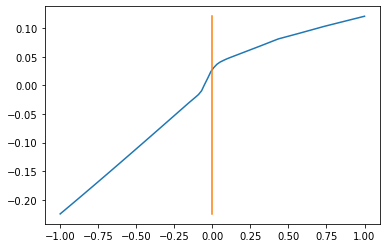

In [15]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = act_net(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [16]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        # action = act_net(obs) * 10
        # action = np.clip(action.numpy(), -1, 1)

        action = act_net(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        # print(obs)

        rewards.append(reward)

        t += 1

        if t == t_max:
            done = True

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

999
success
-0.45037303212464863
999
success
-1.23573783063171



KeyboardInterrupt



## How about multiple runs on-policy?

In [22]:
act_net = HabitualAction(2, 1, [16, 16], action_std_dev=1)

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 16)                48        
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 z_mean (Dense)              (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [23]:
t_max = 1000
num_episodes = 140

min_reward_cutoff = -1000
min_reward_set = -0.5

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    done = False

    obs = env.reset()

    t = 0
    while not done:

        # env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        all_observations.append(obs)

        action = act_net(obs)
        action = action.numpy() + np.random.normal(0, scale=act_net.action_std_dev)

        obs, reward, done, info = env.step(action)
        actions.append(action)

        t += 1

        # # add reward for finishing fast
        # if done:
        #     # print(t_max - t - 1)
        #     reward += (t_max - t - 1)

        rewards.append(reward)


    # # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # o = transform_observations(o, observation_max, observation_min, obs_stddev)
    # actions.append(a)
    # rewards.append(r)
    #
    # all_observations.append(o[:-1])

    all_observations = np.vstack(all_observations)
    all_observations_scaled = np.vstack(all_observations_scaled)
    actions = np.vstack(actions)
    rewards = np.vstack(rewards)
    # rewards[rewards < min_reward_cutoff] = min_reward_set

    # print(rewards)

    # rewards = rewards.reshape(rewards.shape[1])

    # print(all_observations.shape, actions.shape, rewards.shape)

    cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)

    cum_rewards = cum_rewards

    # print(cum_rewards.shape[0])
    loss = act_net.train_on_batch(all_observations, (actions, cum_rewards))
    print(loss)

-24918280.0
-25762674.0
-21707476.0
-24537526.0
-26724022.0
-29321938.0
-24721684.0
-24753178.0
-29217696.0
-23901768.0
-23250934.0
-21614664.0
-25225504.0
-27671112.0
-24211248.0
-22387506.0
-21793436.0
-22149366.0
-29042734.0
-23368906.0
-22298908.0
-27625088.0
-24334880.0
-27358190.0
-24028890.0
-25834142.0
-24986352.0
-24252838.0
-26687924.0
19539540.0
-22535410.0
-28677358.0
-30388226.0
-28176084.0
-24595378.0
-23245630.0
-24112780.0
-25125552.0
-22769584.0
-26319484.0
-22086028.0
-22623436.0
-26514272.0
-22555046.0
-23936410.0
-26322318.0
-24190680.0
-22415414.0
-24813998.0
16619366.0
-23465054.0
-28662860.0
-23356854.0
-24194074.0
-26043494.0
-26976818.0
-24481610.0
-25837142.0
-21981924.0
-28420472.0
-25204588.0
-23620000.0
9339202.0
-21733098.0
-24424810.0
-23793556.0
-22818046.0
13905470.0
-28101988.0
-25237588.0
-25670670.0
-21181916.0
-24348630.0
-24647674.0
-27143676.0
-27215560.0
-24730114.0
-22554524.0
-25442066.0
-27561128.0
-24068054.0
-25180918.0
-23753202.0
-27154528

In [24]:
act_net(all_observations)

<tf.Tensor: shape=(999, 1), dtype=float32, numpy=
array([[0.06133075],
       [0.06203682],
       [0.06261269],
       [0.06261717],
       [0.06229575],
       [0.06168946],
       [0.06088402],
       [0.06118155],
       [0.06051783],
       [0.0606633 ],
       [0.06117065],
       [0.06084234],
       [0.06075777],
       [0.06146242],
       [0.06133082],
       [0.06103873],
       [0.06044308],
       [0.05998818],
       [0.0597015 ],
       [0.05897281],
       [0.05917123],
       [0.05867725],
       [0.05846734],
       [0.05912185],
       [0.05887891],
       [0.05890892],
       [0.05849665],
       [0.05897251],
       [0.05953557],
       [0.06019672],
       [0.06257744],
       [0.06403317],
       [0.06650355],
       [0.06812316],
       [0.06920926],
       [0.07018568],
       [0.07227827],
       [0.07336802],
       [0.07357565],
       [0.07594153],
       [0.07773934],
       [0.07826348],
       [0.07967445],
       [0.08044754],
       [0.07972151],
     

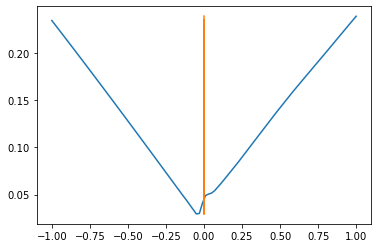

In [25]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = act_net(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

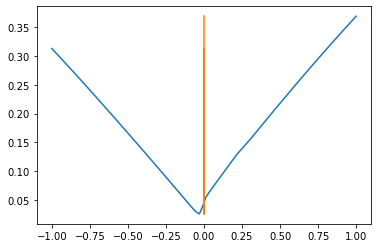

In [26]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = act_net(vel_pos)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [27]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        # action = act_net(obs) * 10
        # action = np.clip(action.numpy(), -1, 1)

        action = act_net(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        t += 1

        if t == t_max:
            done = True

        # if done:
        #     reward += (t_max - t - 1)/10

        rewards.append(reward)

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

999
success
-0.4938332729813938
999
success
-0.5035291879091568
999
success
-0.4859404916922888
999
success
-0.4999256142199371
999
success
-0.5032349099041977
999
success
-0.5138853191812159



KeyboardInterrupt



In [8]:
from prior_model import PriorModelBellman
from train_agent import train_single_model_free_agent
from util import test_policy
import pandas as pd

In [9]:
class A2CAgent:

    def __init__(self, policy_net, value_net, agent_time_ratio):
        self.policy_net = policy_net
        self.value_net = value_net

        self.observation_sequence = []
        self.action_sequence = []
        self.reward_this_run = []

        self.previous_action = None

        self.timestep = 0
        self.agent_time_ratio = agent_time_ratio

    def perceive_and_act(self, observation, reward=None, done=False):
        # print(observation)
        if done:

            self.reward_this_run.append(reward)
            self.observation_sequence.append(observation)
            self.observation_sequence = np.vstack(self.observation_sequence)
            self.action_sequence = np.array(self.action_sequence)
            self.reward_this_run = np.array(self.reward_this_run).reshape(len(self.reward_this_run), 1)
            # print(self.action_sequence.shape)
            # print(self.reward_this_run.shape)

            pre_obs = self.observation_sequence[0:-1]
            post_obs = self.observation_sequence[1:]

            # print(self.observation_sequence.shape)

            # train value model
            self.value_net.train(post_obs, self.reward_this_run)

            # calculate advantage
            v_state = self.value_net(pre_obs)
            v_plus_one_state = self.value_net(post_obs)
            # print(v_state.shape)
            # print(v_plus_one_state.shape)
            advantage = self.reward_this_run + self.value_net.discount_factor * v_plus_one_state - v_state

            print(advantage)

            # train habit net
            self.policy_net.train(pre_obs, self.action_sequence, advantage, post_obs)

        elif self.timestep % self.agent_time_ratio == 0:

            # select the next action
            action = self.policy_net(observation)
            action = tfp.distributions.MultivariateNormalDiag(loc=action, scale_diag=[self.policy_net.action_std_dev]).sample()
            # print(action)
            action = [tf.squeeze(action).numpy()]
            # print(action)

            # update previous values
            self.previous_action = action
            self.observation_sequence.append(observation)
            self.action_sequence.append(action)
            self.timestep += 1

            if reward is not None:
                self.reward_this_run.append(reward)

            return action

        else:
            self.timestep += 1
            return self.previous_action


    def reset_all_states(self):

        self.observation_sequence = []
        self.action_sequence = []
        self.reward_this_run = []

        self.timestep = 0
        self.previous_action = None


In [10]:
def experiment_model_free_a2c(
        experiment_name,
        env,
        observation_min,
        observation_max,
        observation_noise_stddev,
        num_agents,
        normal_runs,
        flip_dynamics_runs,
        episodes_between_habit_tests,
        prior_params,
        a2c_params,
        a2c_agent_time_ratio):

    # track experiment results
    all_results = []
    all_habit_results = []

    for agent_num in range(num_agents):

        # # make the HABIT ACTION NET
        policy_net = HabitualAction(**a2c_params)
        policy_net.compile(optimizer=tf.keras.optimizers.Adam())

        # make the PRIOR NET
        value_net = PriorModelBellman(**prior_params)

        # make the agent
        a2c_agent = A2C(policy_net=policy_net, value_net=value_net, agent_time_ratio=a2c_agent_time_ratio)

        # store and track results for this agent
        full_run_results = []
        full_run_habit_results = []
        habit_run_number = 0

        # Some epochs of VAE
        for n in range(normal_runs):

            a2c_agent, results = train_single_model_free_agent(env, a2c_agent, observation_max, observation_min, observation_noise_stddev, num_episodes=episodes_between_habit_tests, render_env=False)
            full_run_results.append(results)

            p = a2c_agent.policy_net
            res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, a2c_agent.agent_time_ratio)
            res["run_num"] = habit_run_number
            habit_run_number += 1
            full_run_habit_results.append(res)

        # Flip the dynamics
        for n in range(flip_dynamics_runs):

            a2c_agent, results = train_single_model_free_agent(env, a2c_agent, observation_max, observation_min, observation_noise_stddev, num_episodes=episodes_between_habit_tests, render_env=False, flip_dynamics=True)
            full_run_results.append(results)

            p = a2c_agent.select_action
            res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, a2c_agent.agent_time_ratio)
            res["run_num"] = habit_run_number
            habit_run_number += 1
            full_run_habit_results.append(res)

        # collect the results for this agent
        full_run_results = pd.concat(full_run_results)
        full_run_results = full_run_results.reset_index(drop=True)
        full_run_results["episode"] = full_run_results.index
        full_run_results["agent_id"] = agent_num

        full_run_habit_results = pd.concat(full_run_habit_results)
        full_run_habit_results["agent_id"] = agent_num

        # add the results to all the agents
        all_results.append(full_run_results)
        all_habit_results.append(full_run_habit_results)

    # write the final results to csv
    all_results = pd.concat(all_results)
    all_results = all_results.reset_index(drop=True)
    all_habit_results = pd.concat(all_habit_results)
    all_habit_results = all_habit_results.reset_index(drop=True)

    all_results.to_csv(f"{experiment_name}_agent_results.csv")
    all_habit_results.to_csv(f"{experiment_name}_habit_results.csv")

    print("EXPERIMENT FINISHED")

In [11]:
prior_params = {
    "observation_dim": 2,
    "output_dim": 1,
    "iterate_train": 1,
    "discount_factor": 0.99,
    "training_epochs": 1,
    "show_training": False,
    "use_tanh_on_output": False
}

a2c_model_params = {
    "latent_dim": 2,
    "action_dim": 1,
    "dense_units": [16, 16],
    "action_std_dev": 0.05,
    "train_epochs": 2,
    "show_training": False,
    "discount_factor": 0.99
}


observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])
observation_noise_stddev = [0, 0]

num_agents = 2

NORMAL_RUNS = 2
FLIP_DYNAMICS_RUNS = 0
EPISODES_BETWEEN_HABIT_TESTS = 2

experiment_name = "../experiment_results/mf_A2C_test"

# train the agent on the env
env = gym.make('MountainCarContinuous-v0')

experiment_model_free_a2c(
    experiment_name,
    env,
    observation_min,
    observation_max,
    observation_noise_stddev,
    num_agents,
    NORMAL_RUNS,
    FLIP_DYNAMICS_RUNS,
    EPISODES_BETWEEN_HABIT_TESTS,
    prior_params,
    a2c_model_params,
    6)

Episode 1
[-0.5681572  0.       ]
tf.Tensor(
[[-6.87957555e-03]
 [-4.95756045e-03]
 [-2.05583870e-03]
 [ 5.35540469e-03]
 [ 6.15668669e-03]
 [ 7.68416934e-03]
 [ 2.94520985e-03]
 [ 4.35253978e-03]
 [ 1.50906853e-03]
 [-2.49599945e-03]
 [ 2.15847837e-03]
 [-7.04001449e-03]
 [-5.07130846e-03]
 [-2.51296721e-03]
 [-4.20470908e-03]
 [-7.66369700e-03]
 [-4.07541543e-03]
 [ 5.71402162e-03]
 [ 7.10428506e-03]
 [ 1.21269217e-02]
 [ 7.51295686e-03]
 [ 5.16077131e-03]
 [-3.30481911e-04]
 [-5.77201694e-03]
 [-9.14881937e-03]
 [-9.56540368e-03]
 [-9.84768569e-03]
 [-7.29789212e-03]
 [ 1.76541880e-03]
 [ 1.67574733e-03]
 [ 8.22961144e-03]
 [ 1.10827591e-02]
 [ 1.19837578e-02]
 [ 8.72696657e-03]
 [-8.46768264e-04]
 [-4.68824664e-03]
 [-8.48943740e-03]
 [-1.03624966e-02]
 [-1.38570387e-02]
 [-7.26076588e-03]
 [-3.80930305e-03]
 [ 8.43108445e-03]
 [ 1.17135905e-02]
 [ 7.01805390e-03]
 [ 1.51032582e-02]
 [ 9.23832506e-03]
 [ 1.33874360e-03]
 [-4.48487606e-03]
 [-9.66898352e-03]
 [-1.48317236e-02]
 [-2.